# Setting live or non-live nodes

Set a note status to `live=True` or `live=False` based on whether it intersect the original boundary.

This is used for demarcating nodes that fall within the original unbuffered boundary when calculating measures. This allows for the original boundary to be delineated from the buffered surrounding extents, which is normally included for purposes of avoiding edge roll-off. The algorithms will continue to consider parts of the network where nodes are not live (therefore preventing edge roll-off), but will not compute metrics for these nodes (reducing unnecessary computation).


In [1]:
import matplotlib.pyplot as plt
from cityseer.metrics import networks
from cityseer.tools import graphs, io
from shapely import geometry

When using this approach it is best to work in a projector coordinate reference system. In this example we will cast the buffered point polygon to projected CRS by using the `projected=True` parameter.


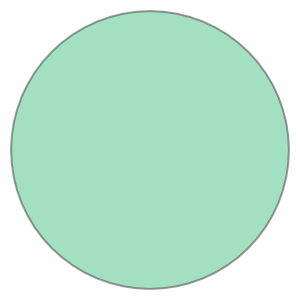

In [2]:
lng, lat = -0.13396079424572427, 51.51371088849723
buffer = 500
poly_utm, epsg_code = io.buffered_point_poly(lng, lat, buffer, projected=True)
poly_utm

Since the Polygon is in a projected CRS, the buffering step can proceed with a distance defined in metres. Here the Polygon is buffered by 400m since this is the maximum distance considered for the centrality analysis in the next step.


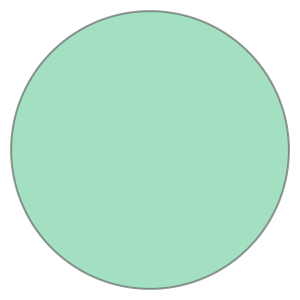

In [3]:
pol_buff = poly_utm.buffer(400)
pol_buff

The buffer polygon can then be used as an argument for retrieving the OSM network. The `poly_crs_code` and `to_crs_code` parameters need to be set so that the function knows which CRS the input geometry is in, and which CRS to convert the network to.


In [4]:
G = io.osm_graph_from_poly(pol_buff, poly_crs_code=epsg_code, to_crs_code=epsg_code)

INFO:cityseer.tools.graphs:Generating interpolated edge geometries.
100%|██████████| 9574/9574 [00:00<00:00, 53513.86it/s]
INFO:cityseer.tools.io:Converting networkX graph to CRS code 32630.
INFO:cityseer.tools.io:Processing node x, y coordinates.
100%|██████████| 8905/8905 [00:00<00:00, 1094674.01it/s]
INFO:cityseer.tools.io:Processing edge geom coordinates, if present.
100%|██████████| 9574/9574 [00:00<00:00, 19250.07it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 8905/8905 [00:00<00:00, 24650.31it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 5145/5145 [00:00<00:00, 10442.56it/s]
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3094/3094 [00:00<00:00, 334782.57it/s]
INFO:cityseer.tools.graphs:Removing dangling nodes.
INFO:cityseer.tools.graphs:Removing filler nodes.
100%|██████████| 3871/3871 [00:00<00:00, 1087703.54it/s]
INFO:cityseer.tools.util:Creating edges STR tree.
100%|██████████| 2952/2952 [00:00<00:00, 17510

Since the network and the source geometry are in the same CRS, it is possible to demarcate each node as either `live=True` or `live=False` based on whether it intersects the original geometry.

This can be done by iterating through the nodes and checking if they intersect the original geometry. If they do, the node is set to `live=True`, otherwise it is set to `live=False`.


In [10]:
for node_idx, node_data in G.nodes(data=True):
    node_pnt = geometry.Point(node_data["x"], node_data["y"])
    if node_pnt.intersects(poly_utm):
        G.nodes[node_idx]["live"] = True
    else:
        G.nodes[node_idx]["live"] = False

Metrics can then be computed based on the target distance without encountering edge roll-off.


In [11]:
G_dual = graphs.nx_to_dual(G)
nodes_gdf, _edges_gdf, network_structure = io.network_structure_from_nx(
    G_dual,
)
distances = [400]
nodes_gdf = networks.node_centrality_shortest(
    network_structure=network_structure,
    nodes_gdf=nodes_gdf,
    distances=distances,
)
nodes_gdf.head()

INFO:cityseer.tools.graphs:Converting graph to dual.
INFO:cityseer.tools.graphs:Preparing dual nodes
100%|██████████| 1314/1314 [00:00<00:00, 36674.13it/s]
INFO:cityseer.tools.graphs:Preparing dual edges (splitting and welding geoms)
100%|██████████| 1314/1314 [00:01<00:00, 751.64it/s]
INFO:cityseer.tools.io:Preparing node and edge arrays from networkX graph.
100%|██████████| 1314/1314 [00:00<00:00, 4381.52it/s]
INFO:cityseer.metrics.networks:Computing shortest path node centrality.
100%|██████████| 1314/1314 [00:01<00:00, 1310.09it/s]
INFO:cityseer.config:Metrics computed for:
INFO:cityseer.config:Distance: 400m, Beta: 0.01, Walking Time: 5.0 minutes.


,ns_node_idx,x,y,live,weight,primal_edge,primal_edge_node_a,primal_edge_node_b,primal_edge_idx,dual_node,cc_beta_400,cc_cycles_400,cc_density_400,cc_farness_400,cc_harmonic_400,cc_hillier_400,cc_betweenness_400,cc_betweenness_beta_400
25257319_25257320_k0,0,698204.726812,5.710187e+06,False,1,"LINESTRING (698235.492 5710213.589, 698232.233...",25257320,25257319,0,POINT (698204.726812 5710187.371082),0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
108252_25257054_k0,1,698153.709285,5.710642e+06,False,1,"LINESTRING (698138.426 5710664.248, 698144.112...",108252,25257054,0,POINT (698153.709285 5710641.538834),0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
108252_452229727_k0,2,698123.239970,5.710685e+06,False,1,"LINESTRING (698138.426 5710664.248, 698133.018...",108252,452229727,0,POINT (698123.23997 5710685.118712),0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
108252_12391|03078±57552|08253_k0,3,698120.890901,5.710655e+06,False,1,"LINESTRING (698103.385 5710645.919, 698131.137...",108252,12391|03078±57552|08253,0,POINT (698120.890901 5710655.116857),0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0
108252_10825|82720±25257|82720±12373|16592_k0,4,698183.290484,5.710684e+06,False,1,"LINESTRING (698228.148 5710703.651, 698222.24 ...",108252,10825|82720±25257|82720±12373|16592,0,POINT (698183.290484 5710683.927691),0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0


Measures will only have been computed for live nodes.


(np.float64(697663.3353532758),
 np.float64(699986.2102806268),
 np.float64(5709670.722888798),
 np.float64(5711930.195587498))

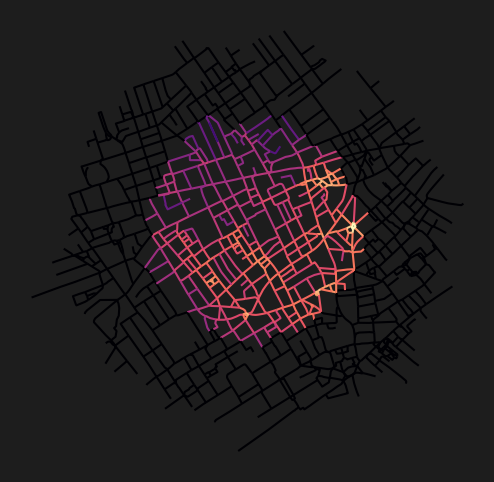

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), facecolor="#1d1d1d")
nodes_gdf.plot(
    column="cc_harmonic_400",
    cmap="magma",
    legend=False,
    ax=ax,
)
ax.axis(False)

To print or save only live nodes, filter the data frame accordingly.


(np.float64(698266.6364452019),
 np.float64(699469.3803111856),
 np.float64(5710222.983618274),
 np.float64(5711471.82779159))

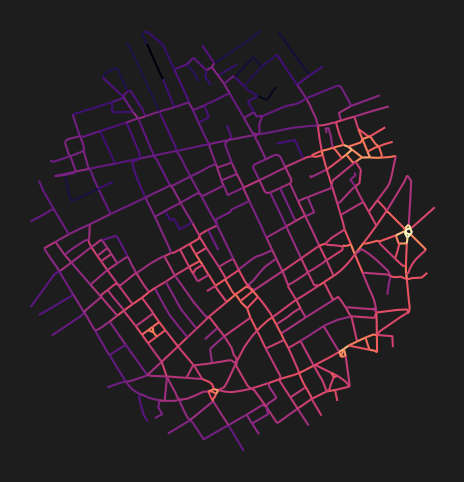

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6), facecolor="#1d1d1d")
nodes_filtered = nodes_gdf[nodes_gdf.live]
nodes_filtered.plot(
    column="cc_harmonic_400",
    cmap="magma",
    legend=False,
    ax=ax,
)
ax.axis(False)